In [1]:
# Import the libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio

In [2]:
# Parameters
output_file = "potential_sites.gpkg"
green_penalty_weight = 0.4
church_penalty_weight = 0.2
noise_penalty_weight = 0.3
senior_penalty_weight = 0.1

In [3]:
# Hard constraints
min_plot_area = 1000 #sqm
max_plot_area = 10000 #sqm
min_shape_index = 0.6
max_distance_to_road = 10 #m

In [4]:
# Read the data
plots = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_dzialki_egib_wfs_gml.gml")
buildings = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_budynki_egib_wfs_gml.gml")
roads = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_ulice_egib_wfs_gml.gml")
local_plans = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/ZbiorAPP_MPZP_Gdansk.gml", layer="AktPlanowaniaPrzestrzennego")
churches = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/churches.gpkg")
green_areas = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/green_areas.gpkg")
noise_map = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/noise/noise_map.gpkg")
neighborhoods = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/rejony_transportowe.gpkg")
city_boundary = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/city_boundary2180.gpkg")

city_boundary.to_crs("EPSG:2177", inplace=True)
plots.set_crs("EPSG:2177", inplace=True)

/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(


,gml_id,coordinates,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,geometry
0,dzialki.446690,"6539425.910000,6028445.960000 6539485.590000,6...",226101_1.0042.652/12,652/12,042,42,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6539485.59 6028457.91, 6539485.34 60..."
1,dzialki.404111,"6540330.740000,6028934.900000 6540338.040000,6...",226101_1.0043.159/6,159/6,043,43,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6540338.04 6028950.66, 6540331.69 60..."
2,dzialki.527661,"6531808.490000,6028335.660000 6531866.710000,6...",226101_1.0003.412,412,Klukowo,3,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6531866.71 6028385.32, 6531823.47 60..."
3,dzialki.529749,"6538886.610000,6022524.810000 6539095.060000,6...",226101_1.0075.138/193,138/193,Ujeścisko,75,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6539095.06 6022574.89, 6539071.08 60..."
4,dzialki.505284,"6558026.700000,6023183.330000 6558170.880000,6...",226101_1.0141.117/36,117/36,Komary,141,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6558055.86 6023220.3, 6558027.7 6023..."
...,...,...,...,...,...,...,...,...,...,...,...
92155,dzialki.448952,"6538585.330000,6024643.180000 6538604.240000,6...",226101_1.0064.704/1,704/1,064,64,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6538604.24 6024646.82, 6538585.33 60..."
92156,dzialki.306264,"6536285.160000,6027558.090000 6536292.560000,6...",226101_1.0028.380,380,028,28,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6536292.56 6027558.39, 6536292.4 602..."
92157,dzialki.494343,"6536258.810000,6022259.150000 6536263.830000,6...",226101_1.0048.182/1,182/1,Szadółki,48,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6536263.83 6022299.05, 6536259.3 602..."
92158,dzialki.46783,"6537537.690000,6028852.570000 6537545.050000,6...",226101_1.0030.21/3,21/3,030,30,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6537545.05 6028852.57, 6537540.98 60..."


## Filter the plots according to the hard constraints


In [5]:
# Area constraint
print(f"Total number of plots: {len(plots)}")
plots["area"] = plots.area
sized_plots = plots[(plots["area"] > min_plot_area) & (plots["area"] < max_plot_area)]
print(f"Plots after size filtering: {len(sized_plots)}")

# Regular shape constraint
def calculate_shape_index(geometry):
    area = geometry.area
    perimeter = geometry.length
    return 4 * np.pi * area / (perimeter ** 2)

sized_plots['shape_index'] = sized_plots['geometry'].apply(calculate_shape_index)
shaped_plots = sized_plots[sized_plots['shape_index'] > min_shape_index]
print(f"Plots after shape filtering: {len(shaped_plots)}")

# No local plan constraint
area_with_local_plan = local_plans.dissolve(by="przestrzenNazw")
plots_with_plans = gpd.sjoin(
    shaped_plots, 
    area_with_local_plan, 
    how='inner'
)

shaped_plots_without_plan = shaped_plots[~shaped_plots.index.isin(plots_with_plans.index)]
print(f"Plots after local plan filtering: {len(shaped_plots_without_plan)}")
# No residential buildings constraint
residential_buildings = buildings[buildings['RODZAJ'] == 'm']


# Find plots that intersect with residential buildings
plots_with_buildings = gpd.sjoin(
    shaped_plots_without_plan,
    residential_buildings,
    how='inner'
)

# Keep only plots that didn't match any residential buildings
empty_plots_without_plan = shaped_plots_without_plan[
    ~shaped_plots_without_plan.index.isin(plots_with_buildings.dropna().index)
]

print(f"Plots after residential buildings filtering: {len(empty_plots_without_plan)}")

# Create buffered roads GeoDataFrame
buffered_roads_gdf = gpd.GeoDataFrame(
    geometry=roads.buffer(max_distance_to_road),
    crs=roads.crs
)

# Find plots that intersect with buffered roads and remove duplicates
potential_sites = (gpd.sjoin(
    empty_plots_without_plan,
    buffered_roads_gdf,
    how='inner'
)
.loc[lambda x: ~x.index.duplicated(keep='first')])  # Remove duplicates while preserving the GeoDataFrame

print(f"Plots after public road accessibility filtering: {len(potential_sites)}")

# Save the potential sites to a file
potential_sites.to_file(output_file)
print(f"Potential sites saved to {output_file}")

Total number of plots: 92160
Plots after size filtering: 23416
Plots after shape filtering: 10708


/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Plots after local plan filtering: 2237
Plots after residential buildings filtering: 1330
Plots after public road accessibility filtering: 708
Potential sites saved to potential_sites.gpkg


## Calculate the metrics for retirement home location

In [6]:
def normalize(series):
    # For metrics where lower is better (like noise, distance)
    normalized = (series - series.min()) / (series.max() - series.min())
    return normalized

def compute_distance_to_nearest_target(centroid, target_gdf):
    distances = [centroid.distance(target_geom) for target_geom in target_gdf.geometry.values]
    return round(min(distances))


In [7]:
potential_sites['centroid'] = potential_sites.centroid


potential_sites["distance_to_nearest_church"] = potential_sites.apply(
    lambda row: compute_distance_to_nearest_target(
        row['centroid'], 
        churches
    ),
    axis=1
)

potential_sites["church_penalty"] = normalize(potential_sites["distance_to_nearest_church"])


In [8]:
potential_sites["distance_to_nearest_green"] = potential_sites.apply(
    lambda row: compute_distance_to_nearest_target(
        row['centroid'],
        green_areas
    ),
    axis=1
)

potential_sites["green_penalty"] = normalize(potential_sites["distance_to_nearest_green"])


In [9]:
# Calculate noise level at each potential site using polygon intersection
# First get all intersecting noise polygons for each site
intersections = gpd.sjoin(
    potential_sites[['geometry']],
    noise_map[['geometry', 'min_noise']],
    predicate='intersects'
)
# Group by the index from potential_sites and take the mean noise level
mean_noise = intersections.groupby(level=0)['min_noise'].mean()
potential_sites["noise_level"] = mean_noise

# Replace NaN values in noise_level with 50 dB
potential_sites["noise_level"] = potential_sites["noise_level"].fillna(50)

potential_sites["noise_penalty"] = normalize(np.log(potential_sites["noise_level"]))

In [10]:
# Calculate senior density at each potential site
# Open the raster file
with rasterio.open("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/old_heatmap.tif") as src:
    # Get the raster values at each centroid
    potential_sites['senior_density'] = [
        round(list(src.sample([(geom.x, geom.y)]))[0][0], 1)
        for geom in potential_sites['centroid']
    ]

potential_sites["senior_penalty"] = 1 - normalize(potential_sites["senior_density"])

In [11]:
# Calculate a combined score for each site
potential_sites['combined_score'] = (
    potential_sites['green_penalty'] * green_penalty_weight + 
    potential_sites['church_penalty'] * church_penalty_weight +
    potential_sites['noise_penalty'] * noise_penalty_weight +
    potential_sites['senior_penalty'] * senior_penalty_weight
)

best_sites = potential_sites.nsmallest(9, 'combined_score').copy()
best_sites

,gml_id,coordinates,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,...,centroid,distance_to_nearest_church,church_penalty,distance_to_nearest_green,green_penalty,noise_level,noise_penalty,senior_density,senior_penalty,combined_score
33489,dzialki.32856,"6538177.370000,6032213.550000 6538217.490000,6...",226101_1.0015.342,342,015,15,01_1,M.Gdańsk,2,2024-10-15 21:30:16,...,POINT (6538198.23 6032237.824),664,0.181743,15,0.009102,50.0,0.0,39.400002,0.255198,0.065509
55603,dzialki.490123,"6536098.100000,6023717.530000 6536155.140000,6...",226101_1.0049.222/4,222/4,Jasień,49,01_1,M.Gdańsk,7,2024-10-15 21:30:16,...,POINT (6536127.117 6023732.469),351,0.095422,14,0.008495,50.0,0.0,23.900000,0.548204,0.077303
91480,dzialki.307675,"6539387.390000,6026753.080000 6539448.540000,6...",226101_1.0054.198,198,054,54,01_1,M.Gdańsk,4,2024-10-15 21:30:16,...,POINT (6539412.223 6026783.062),502,0.137066,24,0.014563,50.0,0.0,24.400000,0.538752,0.087114
67922,dzialki.238458,"6536237.640000,6023858.990000 6536286.400000,6...",226101_1.0049.162/2,162/2,Jasień,49,01_1,M.Gdańsk,7,2024-10-15 21:30:16,...,POINT (6536261.798 6023882.791),390,0.106178,72,0.043689,50.0,0.0,26.500000,0.499055,0.088617
15299,dzialki.491427,"6537363.140000,6025200.520000 6537416.190000,6...",226101_1.0052.42/56,42/56,052,52,01_1,M.Gdańsk,5,2024-10-15 21:30:16,...,POINT (6537390.516 6025218.93),510,0.139272,156,0.094660,50.0,0.0,37.099998,0.298677,0.095586
65037,dzialki.512446,"6541043.760000,6017787.380000 6541155.720000,6...",226101_1.0318.4/3,4/3,318S,318,01_1,M.Gdańsk,7,2024-10-15 21:30:16,...,POINT (6541106.564 6017835.806),336,0.091285,0,0.000000,50.0,0.0,11.700000,0.778828,0.096140
26489,dzialki.53570,"6540781.520000,6030476.070000 6540841.100000,6...",226101_1.0034.371,371,034,34,01_1,M.Gdańsk,4,2024-10-15 21:30:16,...,POINT (6540809.993 6030525.177),292,0.079151,107,0.064927,50.0,0.0,22.299999,0.578450,0.099646
54863,dzialki.273727,"6533217.080000,6022798.450000 6533271.790000,6...",226101_1.0036.329/17,329/17,Kiełpino Górne,36,01_1,M.Gdańsk,7,2024-10-15 21:30:16,...,POINT (6533243.813 6022818.056),446,0.121622,21,0.012743,50.0,0.0,14.700000,0.722117,0.101633
12849,dzialki.526922,"6533261.550000,6022778.860000 6533300.490000,6...",226101_1.0036.330,330,Kiełpino Górne,36,01_1,M.Gdańsk,4,2024-10-15 21:30:16,...,POINT (6533281.056 6022802.565),442,0.120518,20,0.012136,50.0,0.0,14.000000,0.735350,0.102493


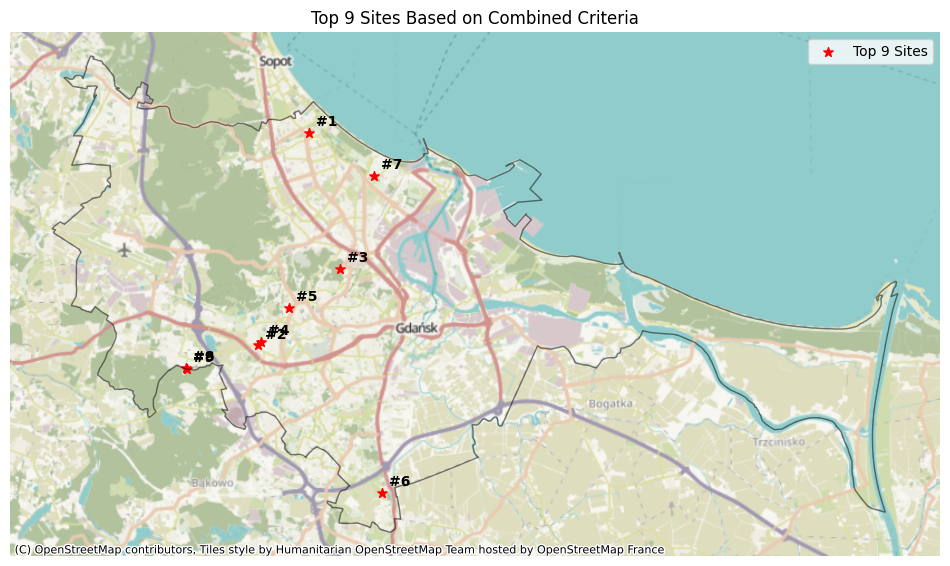

In [12]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))


# Plot the city boundary
city_boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5)

# Plot the centroids of the 10 best sites
best_sites['centroid'].plot(
    ax=ax,
    color='red',
    marker='*', 
    markersize=50,
    label='Top 9 Sites'
)

# Add labels with ranking
for idx, site in best_sites.iterrows():
    rank = best_sites.index.get_loc(idx) + 1
    ax.annotate(
        f'#{rank}',
        xy=(site.centroid.x, site.centroid.y),
        xytext=(5, 5),
        textcoords='offset points',
        color='black',
        fontweight='bold'
    )
ctx.add_basemap(ax, crs=2177)
ax.set_axis_off()

plt.title('Top 9 Sites Based on Combined Criteria')
plt.legend()

### Zoom to the best sites

/var/folders/j5/0qh0dgj5607fhs9231nrxjww0000gn/T/ipykernel_49856/1271650322.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


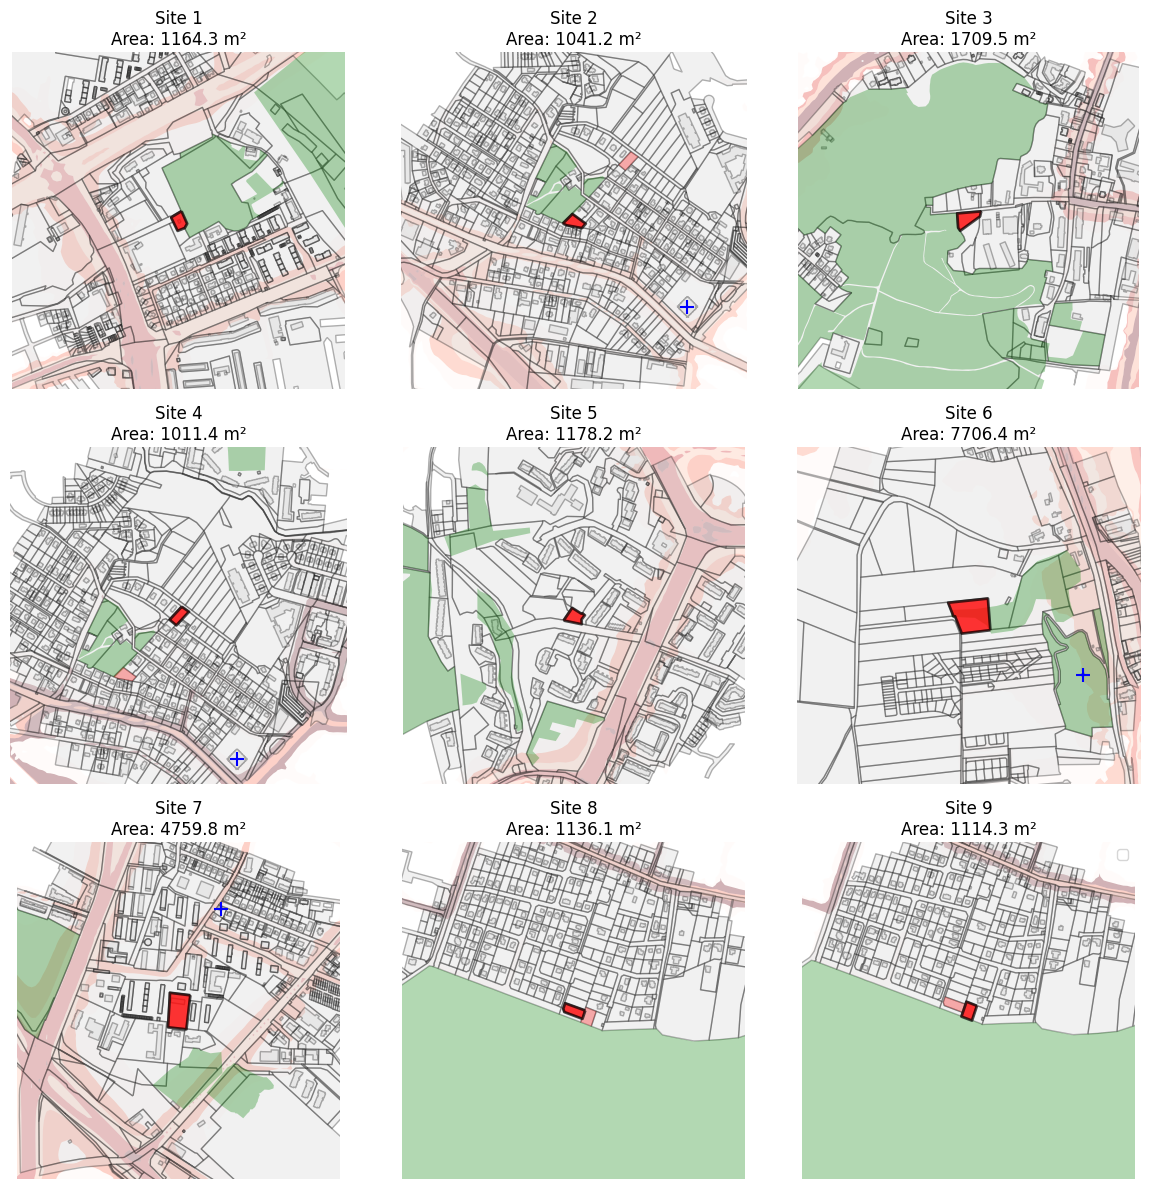

In [13]:
buffer_distance = 300

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx in range(len(best_sites)):
    ax = axes[idx]
    site = best_sites.iloc[idx]

    # Create buffer
    buffer = site.geometry.buffer(buffer_distance+100)
    
    # Filter and plot background features
    noise_map_in_view = noise_map[noise_map.intersects(buffer)]
    plots_in_view = plots[plots.intersects(buffer)]
    buildings_in_view = buildings[buildings.intersects(buffer)]
    green_areas_in_view = green_areas[green_areas.intersects(buffer)]
    pow_in_view = churches[churches.intersects(buffer)]
    best_sites_in_view = best_sites[best_sites.intersects(buffer)]
    
    # Plot layers
    noise_map_in_view.plot(ax=ax, cmap='Reds', alpha=0.3)
    plots_in_view.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)
    buildings_in_view.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)
    green_areas_in_view.plot(ax=ax, color='green', alpha=0.3)
    if len(pow_in_view) > 0:
        pow_in_view.plot(ax=ax, color='blue', marker='+', markersize=100)
    best_sites_in_view.plot(ax=ax, facecolor='red', alpha=0.3)
    
    # Highlight the site
    site_gdf = gpd.GeoDataFrame(geometry=[site.geometry], crs=2177)
    site_gdf.plot(ax=ax, facecolor='red', edgecolor='black', alpha=0.7, linewidth=2)
    
    # Set bounds
    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    
    ax.set_title(f'Site {idx+1}\nArea: {site.area:.1f} m²')
    ax.set_axis_off()

plt.tight_layout()
plt.legend()

In [14]:
# Print detailed information about each site
print("\nDetailed information for top sites:")
for idx, site in best_sites.iterrows():
    print(f"\nSite {idx}:")
    print(f"Area: {site.area:.0f}m2")
    print(f"Combined Score: {site.combined_score:.3f}")
    print(f"Seniors in area: {site.senior_density:.1f}%")
    print(f"Noise Level: {site.noise_level:.0f} dB")
    print(f"Distance to nearest church: {site.distance_to_nearest_church:.0f}m")
    print(f"Distance to nearest green area: {site.distance_to_nearest_green:.0f}m")



Detailed information for top sites:

Site 33489:
Area: 1164m2
Combined Score: 0.066
Seniors in area: 39.4%
Noise Level: 50 dB
Distance to nearest church: 664m
Distance to nearest green area: 15m

Site 55603:
Area: 1041m2
Combined Score: 0.077
Seniors in area: 23.9%
Noise Level: 50 dB
Distance to nearest church: 351m
Distance to nearest green area: 14m

Site 91480:
Area: 1709m2
Combined Score: 0.087
Seniors in area: 24.4%
Noise Level: 50 dB
Distance to nearest church: 502m
Distance to nearest green area: 24m

Site 67922:
Area: 1011m2
Combined Score: 0.089
Seniors in area: 26.5%
Noise Level: 50 dB
Distance to nearest church: 390m
Distance to nearest green area: 72m

Site 15299:
Area: 1178m2
Combined Score: 0.096
Seniors in area: 37.1%
Noise Level: 50 dB
Distance to nearest church: 510m
Distance to nearest green area: 156m

Site 65037:
Area: 7706m2
Combined Score: 0.096
Seniors in area: 11.7%
Noise Level: 50 dB
Distance to nearest church: 336m
Distance to nearest green area: 0m

Site 264